## Malaria Detection Model

This is a CNN model to detect and diagnose Malaria parasites Plasmodium falciparum (or P. falciparum) Plasmodium malariae (or P. malariae). The model was trained with 22000 different blood samples, 2700 Validation sample and 2700 test samples.

The Goal is to detect whether the blood cells are parasitic or uninfected

In [47]:
#Modules
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading dataset

In [3]:
dataset, dataset_info = tfds.load('malaria', with_info=True,
                                  split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], shuffle_files=True)

In [4]:
dataset

[<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>]

In [5]:
train_data = dataset[0]
val_data = dataset[1]
test_data = dataset[2]

In [6]:
len(train_data), len(val_data), len(test_data)

(22046, 2756, 2756)

In [7]:
for i in train_data.take(1):
    print(i)

{'image': <tf.Tensor: shape=(145, 148, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=1>}


## Splitting data

In [8]:
def split(dataset, train_ratio, val_ratio, test_ratio):
  dataset_size = len(dataset)

  train_data = dataset.take(int(train_ratio * dataset_size))
  val_test_ds = dataset.skip(int(train_ratio * dataset_size))
  val_data = val_test_ds.take(int(val_ratio * dataset_size))
  test_data = val_test_ds.skip(int(val_ratio*dataset_size))

  return train_data, val_data, test_data

In [9]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Assuming 'dataset' is a list and you want to split the first element (index 0)
train_ds, val_ds, test_ds = split(dataset[0], train_ratio, val_ratio, test_ratio)

In [10]:
len(train_ds), len(val_ds)

(17636, 2204)

In [11]:
def get_label_str(label):
  if label == 1:
    return 'Uninfected'
  else:
    return 'Infected'

## Visualizing

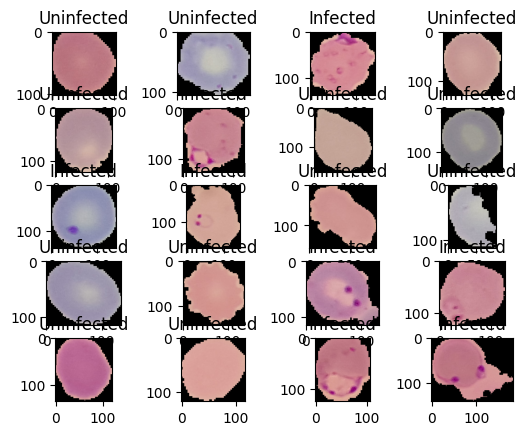

In [12]:
for i, sample in enumerate(train_ds.take(20)):
  ax = plt.subplot(5,4,i+1)
  plt.imshow(sample['image'])
  plt.title(get_label_str(sample['label'].numpy()))

In [13]:
img_size = 224
BATCH_SIZE=32

In [14]:
def resize_img(input):
  return tf.image.resize(input['image'], (img_size, img_size))/255, input['label']

## Batching

In [15]:
train_dataset = train_ds.map(resize_img).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_ds.map(resize_img).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_ds.map(resize_img).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


## Model Construction

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (img_size, img_size, 3)),
    #convolution layer
    Conv2D(filters = 6, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    #convolution layer
    Conv2D(filters = 16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),
    Dense(100, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

In [25]:
model.compile(
    optimizer= Adam(learning_rate=0.01),
    loss=BinaryCrossentropy(),
    metrics=['accuracy']
)

## Training the model

In [26]:
trained = model.fit(train_dataset,
                    validation_data = val_dataset,
                    epochs = 30,
                    verbose=2)

Epoch 1/30
552/552 - 38s - loss: 0.3406 - accuracy: 0.8578 - val_loss: 0.5219 - val_accuracy: 0.8144 - 38s/epoch - 69ms/step
Epoch 2/30
552/552 - 46s - loss: 0.2108 - accuracy: 0.9282 - val_loss: 0.5544 - val_accuracy: 0.5921 - 46s/epoch - 84ms/step
Epoch 3/30
552/552 - 43s - loss: 0.1898 - accuracy: 0.9388 - val_loss: 0.1968 - val_accuracy: 0.9378 - 43s/epoch - 77ms/step
Epoch 4/30
552/552 - 32s - loss: 0.1749 - accuracy: 0.9444 - val_loss: 0.7348 - val_accuracy: 0.5277 - 32s/epoch - 59ms/step
Epoch 5/30
552/552 - 33s - loss: 0.1752 - accuracy: 0.9428 - val_loss: 0.3172 - val_accuracy: 0.8961 - 33s/epoch - 59ms/step
Epoch 6/30
552/552 - 33s - loss: 0.1536 - accuracy: 0.9499 - val_loss: 0.1634 - val_accuracy: 0.9474 - 33s/epoch - 60ms/step
Epoch 7/30
552/552 - 36s - loss: 0.1399 - accuracy: 0.9551 - val_loss: 0.2967 - val_accuracy: 0.9215 - 36s/epoch - 64ms/step
Epoch 8/30
552/552 - 42s - loss: 0.1261 - accuracy: 0.9597 - val_loss: 0.4819 - val_accuracy: 0.6933 - 42s/epoch - 76ms/step


## Evaluation

In [27]:
model.evaluate(val_dataset)

69/69 [==============================] - 11s 32ms/step - loss: 0.6624 - accuracy: 0.9446


[0.6624442338943481, 0.9446461200714111]

In [30]:
trained.history['accuracy']

[0.8578475713729858,
 0.9281582832336426,
 0.9388183355331421,
 0.9444318413734436,
 0.9427874684333801,
 0.9498752355575562,
 0.9550918340682983,
 0.9596847295761108,
 0.961782693862915,
 0.9671694040298462,
 0.9704581499099731,
 0.9740303754806519,
 0.9751644134521484,
 0.9833862781524658,
 0.9824790358543396,
 0.9840666651725769,
 0.986674964427948,
 0.9837831854820251,
 0.9867317080497742,
 0.9910977482795715,
 0.992742121219635,
 0.9876388907432556,
 0.9887162446975708,
 0.9905307292938232,
 0.989623486995697,
 0.9945566058158875,
 0.9964844584465027,
 0.9888863563537598,
 0.9920616745948792,
 0.9969947934150696]

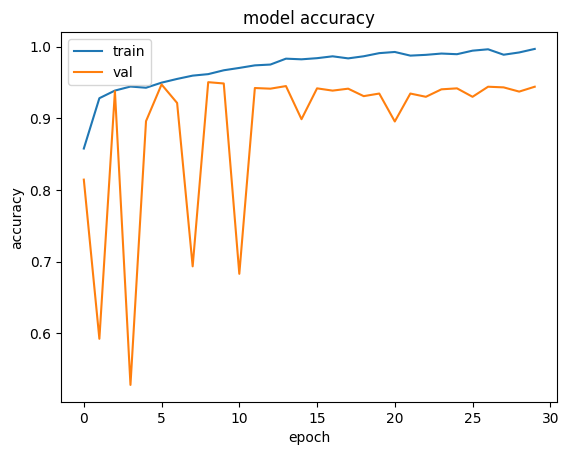

In [31]:
plt.plot(trained.history['accuracy'])
plt.plot(trained.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


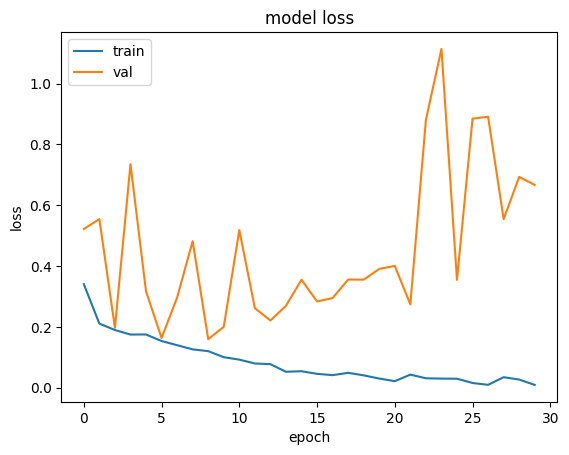

In [33]:
plt.plot(trained.history['loss'])
plt.plot(trained.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [34]:
model.evaluate(test_dataset)

69/69 [==============================] - 14s 36ms/step - loss: 0.5724 - accuracy: 0.9356


[0.5723770260810852, 0.9356300830841064]

In [36]:
model.evaluate(val_dataset)

69/69 [==============================] - 11s 33ms/step - loss: 0.6624 - accuracy: 0.9446


[0.6624441742897034, 0.9446461200714111]

## Prediction

In [44]:
def parasites_or_not(x):
  if x<0.5:
    return str('P') #for parasitic
  else:
    return str('U') #for uneffected

In [42]:
parasites_or_not(model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 10s 10s/step


'P'

1/1 [==============================] - 0s 25ms/step


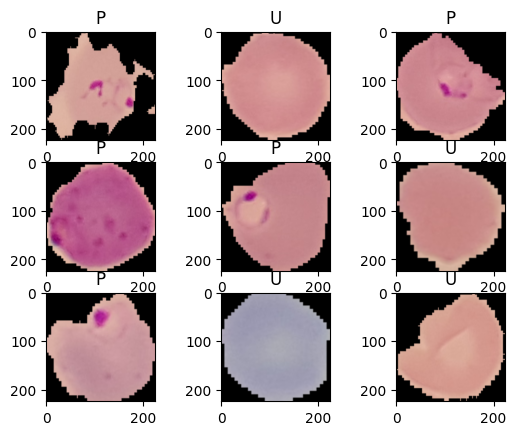

In [46]:
for image, label in test_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image[i])
    plt.title(parasites_or_not(model.predict(image)[i][0]))

## The Model supposedly predicting 94.4% accuracy. In the above output, P stands for Parasitic blood and U stands for Uninfected

## Saving & Loading Model

In [ ]:
model.save('./drive/MyDrive/malaria_model/model_base.h5')

In [ ]:
loaded_model = tf.keras.models.load_model('./drive/MyDrive/malaria_model/model_base.h5')
loaded_model.summary()